<hr style="border: solid 3px blue;">

# Introduction

![](https://miro.medium.com/max/1400/1*RVsX901R3uAFhGD_qTWoSA.gif)

Picture Credit: https://miro.medium.com

Autoencoder is a neural network that simply copies input to output. In some ways, it looks like a simple neural network, but it makes a difficult neural network by constraining the network in various ways. For example, the number of neurons in the hidden layer is smaller than that of the input layer to compress the data (reduce the dimension), or add noise to the input data and then restore the original input. There are various autoencoders, such as learning These constraints prevent the autoencoder from simply copying the input directly to the output, and control it to learn how to represent the data efficiently.

In this notebook, we will cover two autoencoders:
* **Base AutoEncoder**
* **Denoising Autoencoder**


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2022-02-14 01:36:40.193914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


-------------------------------------
# Loading and Scaling Datasets
Train a basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels.
Inputs are scaled for training.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


--------------------------
## Checking dataset by 2D plot

Autoencoding can be thought of as a kind of dimensionality reduction process. Therefore, after compressing the fashion MNIST dataset through UMAP in two dimensions, let's check how it is mapped for each label.

In [3]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

In [4]:
labels = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
          5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

In [5]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train["class"].replace(labels, inplace=True)

<AxesSubplot:>

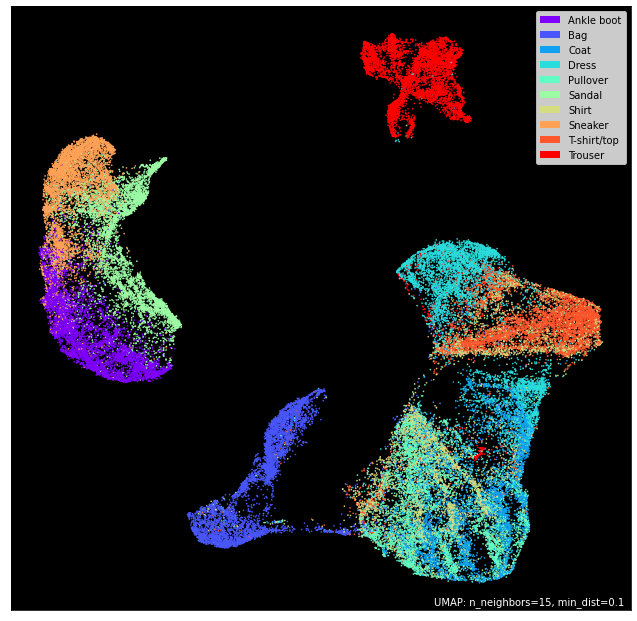

In [6]:
import umap.plot
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train["class"], theme='fire')

Looking at the distribution of data projected in two dimensions, it seems that compression with an autoencoder would be sufficient.

<AxesSubplot:>

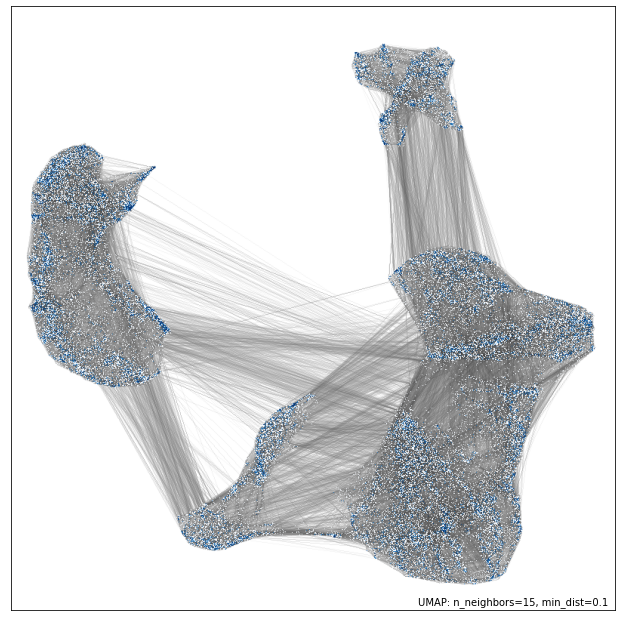

In [7]:
umap.plot.connectivity(mapper_org, show_points=True)

> UMAP works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. In practice this structure can be simplified down to a weighted graph. Sometimes it can be beneficial to see how that graph (representing connectivity in the manifold) looks with respect to the resulting embedding. It can be used to better understand the embedding, and for diagnostic purposes. 

Ref: https://umap-learn.readthedocs.io/en

## Checking dataset by 3D plot

In [8]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(x_train_flat)
umap_df = pd.DataFrame(x_umap)
new_df = pd.concat([umap_df,y_train["class"]],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='class', labels={'color': 'class'}
)
fig.update_traces(marker_size=1)
fig.show()

We have approximated the distribution of the training dataset we want to train with 2D and 3D compressed datasets. Autoencoder is another compression method using neural networks.

**Now, let's do modeling and training for Autoencoder.**

<hr style="border: solid 3px blue;">

# Base Autoencoder



## Modeling
An autoencoder always consists of two parts: an encoder and a decoder.
* Encoder (Recognition network): it transforms an input into an internal representation.
* Decoder (generative network): it transforms an internal representation into an output.

The autoencoder has the same structure as a general MLP (Multi-Layer Perceptron) except that the number of neurons in the input and output layers is same. Since the autoencoder reconstructs the input, the output is also called reconstruction, and the loss function is calculated with the difference between the input and the reconstruction (output).

The neurons (nodes, units) of the hidden layer are smaller than the input layer, so the input is expressed in a low-dimensional manner. Such an autoencoder is called an undercomplete autoencoder. Because an undercomplete autoencoder cannot copy the input to the output as it is by a hidden layer with low dimensions, the output must learn to output the same as the input. Through this learning, the undercomplete autoencoder learns the most important features from the input data.

In [9]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(latent_dim, activation='relu'),  
    ])                                   # (1,784)(784,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))           # (1,64)(64,784) => (1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim)

2022-02-14 01:40:07.561520: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-14 01:40:07.564136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-14 01:40:07.566484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 01:40:07.567230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-14 01:40:07.567292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-14 01:40:07.567419: I tensorflow/stream_executor/platform/def

In [10]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Training

Train the model using x_train as input and target. The encoder learns to compress the dataset into a latent space in 784 dimensions, and the decoder learns to reconstruct the original image.

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

2022-02-14 01:40:12.303452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-14 01:40:12.313963: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/10


2022-02-14 01:40:12.731316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


 117/1875 [>.............................] - ETA: 2s - loss: 0.1064

2022-02-14 01:40:13.483373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


1875/1875 [==============================] - 5s 2ms/step - loss: 0.0401 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0087 - val_los

In [12]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

## Plotting the latent space after Dimension Reduction

In [13]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test["class"].replace(labels, inplace=True)

<AxesSubplot:>

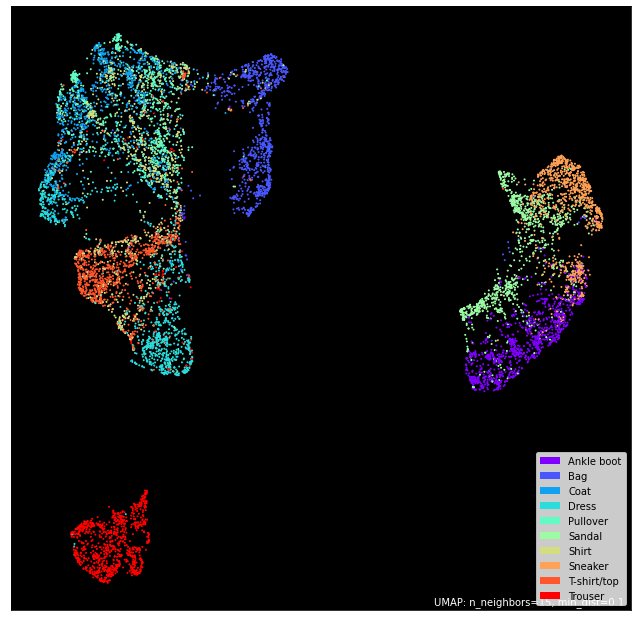

In [14]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

The $28*28$ dimension input is compressed into the $7*7$ latent space by the encoder. The latent space is compressed into 2D using Dimension Reduction. Although it is an approximate expression, it can be seen that each class is well clustered in the compressed latent space.

## Checking results

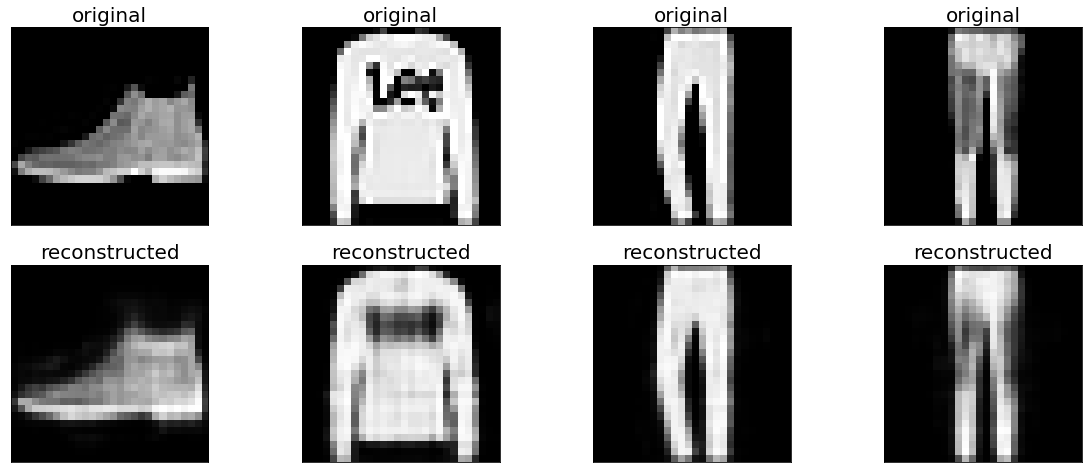

In [15]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Looking at the result, the reconstructed image looks a little blurry. However, it can be confirmed that the overall characteristics are expressed.

<hr style="border: solid 3px blue;">

# Denoising Autoencoder

Another way to constrain the autoencoder to learn meaningful features is to add noise to the input and train it to reconstruct the original noise-free input. Noise can be generated by adding Gaussian noise to the input as shown in the figure below, or by randomly turning off the input unit (node) like a dropout.

In [16]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


## Adding random noise to the image.

In [18]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

## Plotting a noisy image.

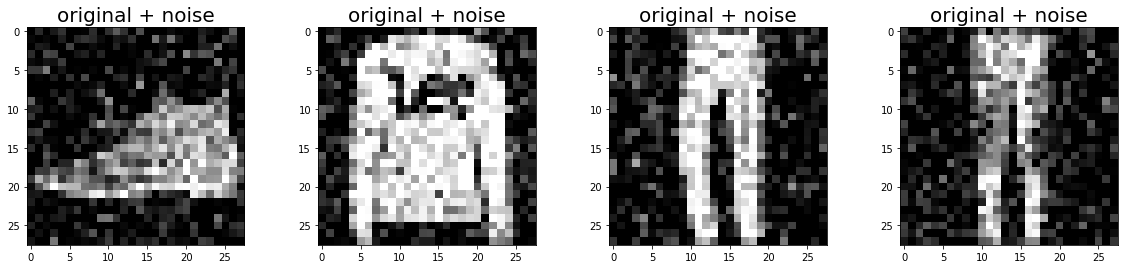

In [19]:
n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Checking Noisy Dataset using Demension Reduction

### 1) Noisy Dataset

In [20]:
x_train_noisy_flat = x_train.reshape(x_train_noisy.shape[0], -1)

In [21]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train["class"].replace(labels, inplace=True)

<AxesSubplot:>

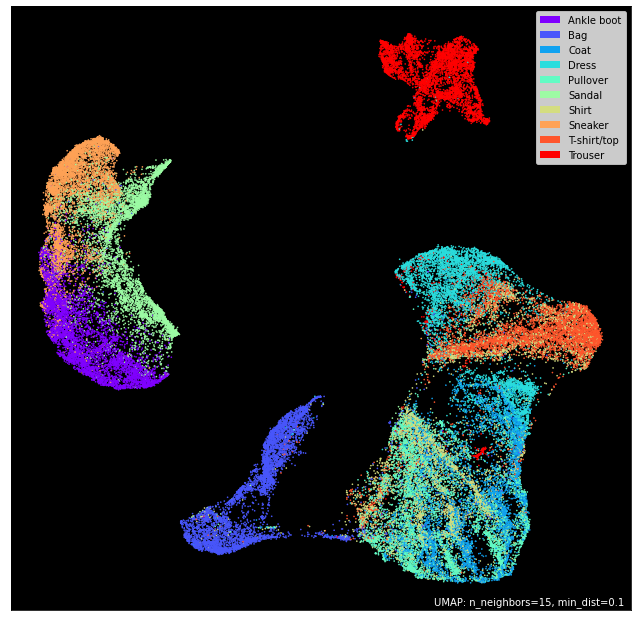

In [22]:
mapper_noisy = umap.UMAP().fit(x_train_noisy_flat)
umap.plot.points(mapper_noisy, labels=y_train['class'], theme='fire')

### 2) Orignal Dataset

In [23]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

<AxesSubplot:>

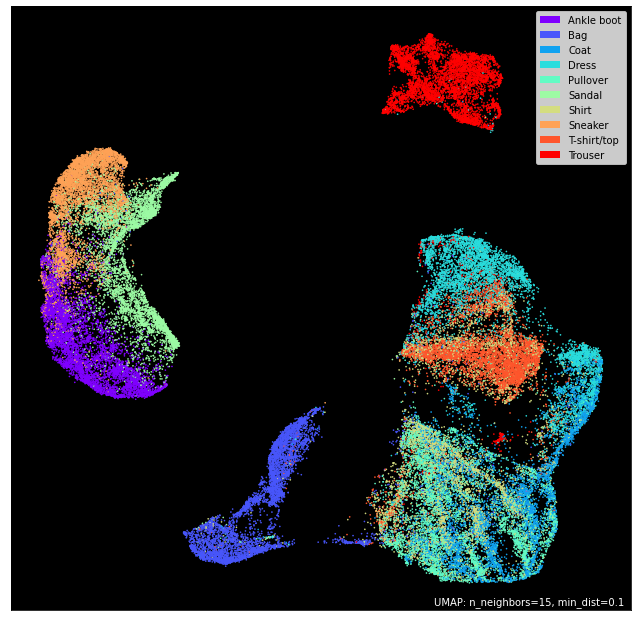

In [24]:
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train['class'], theme='fire')

When looking at the two-dimensionally scaled-down pictures, the difference is not very visible. However, if you look at the picture on the upper right, you can see that the distribution of the blue dots is slightly different. Also, the distribution of purple has changed.
In any case, the visually large noise does not show much difference after dimensionality reduction.

The image observed with our eyes may appear to be noisy, but from the model's point of view the noise may not be so great!

Now let's do some modeling and training with this noisy dateset.

## Modeling

In [25]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [26]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Training

In [27]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


2022-02-14 01:43:36.231932: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1875/1875 [==============================] - 11s 3ms/step - loss: 0.0351 - val_loss: 0.0101
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0073 - val_lo

Let's take a look at the encoder summary. The image is downsampled from 28x28 to 7x7.

In [28]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the image back from 7x7 to 28x28.

In [29]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


## Checking results

Plots both the noisy and denoised images generated by the autoencoder.

In [30]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

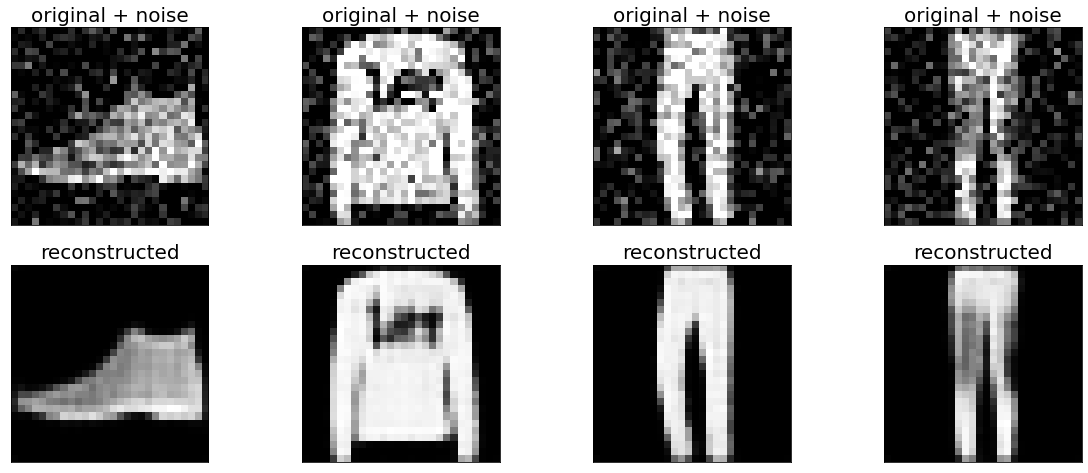

In [31]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed",fontsize=20)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

**Looking at the reconstructed pictures, it can be seen that the noise has been removed.**

----------------------------------